## Check The DL-DFT for some important configurations

#### Test the neural network

Imports

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Data

In [11]:
l=8
data=np.load('data/disorder/tddft_periodic_driving_a_2_w_2_l_8_n_10.npz')

z=data['density']
f=data['density_F']

z_torch=torch.tensor(z,dtype=torch.double)


model=torch.load('model_rep/adiabatic_tddft/model_zzxz_reduction_150k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock',map_location='cpu')
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'data/disorder/tddft_periodic_driving_a_2_w_2_l_8_n_10.npz'

Test the neural network

In [3]:
f_ml=model(z_torch).detach().cpu().numpy()
df=np.abs(np.average(f_ml-f,axis=-1))/np.abs(np.average(f,axis=-1))


Visualization

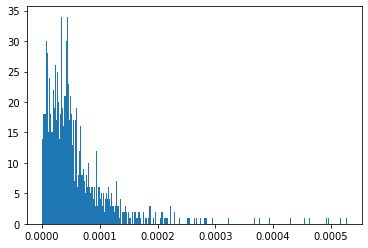

In [4]:
plt.hist(df,bins=300)
plt.show()

#### Use the Runge-Kutta Theorem

Imports

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.tddft_methods.adiabatic_tddft import AdiabaticTDDFT

Data

In [4]:
data=np.load('data/uniform/test_for_adiabatic_uniform_size_8_tf_10.0_dt_0.01_rate_0.5_h_2.7_n_dataset_10.npz')

z=data['density']
h=data['potential']
time=data['time']
dt=time[1]-time[0]
new_time=np.linspace(0,time[-1],1000)
print(time[0])
model=torch.load('model_rep/kohm_sham/uniform/model_zzxz_reduction_150k_unet_l_train_8_[40, 40, 40, 40, 40, 40]_hc_5_ks_1_ps_6_nconv_0_nblock',map_location='cpu')
model.eval()
print(model)
l=h.shape[-1]
idx=1


#samples for pca
nsamples=100
indices=np.random.randint(0,h.shape[0]*h.shape[1],size=nsamples)
samples_numpy=np.take(h.reshape(-1,l),indices=indices,axis=0)
sample_for_projection=torch.from_numpy(samples_numpy)

z_torch=torch.from_numpy(z[idx])
h_torch=torch.from_numpy(h[idx])



0.0
TDDFTadiabaticModel(
  (conv_downsample): ModuleList(
    (0): Sequential(
      (conv1): Conv1d(1, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 1): GELU()
    )
    (1): Sequential(
      (conv2): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 2): GELU()
    )
    (2): Sequential(
      (conv3): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 3): GELU()
    )
    (3): Sequential(
      (conv4): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 4): GELU()
    )
    (4): Sequential(
      (conv5): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation 5): GELU()
    )
    (5): Sequential(
      (conv6): Conv1d(40, 40, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=circular)
      (activation_6): GELU()
    )
  )
  (conv_upsampl

Initial state from $\mathbf{z}$

In [2]:
psi=torch.zeros(size=(l,2),dtype=torch.complex128)
psi[:,1]=torch.sqrt((1-z_torch[0])/2)
psi[:,0]=torch.sqrt((1+z_torch[0])/2)

print(psi[:,0]**2-psi[:,1]**2,z_torch[0])

NameError: name 'torch' is not defined

Evolution by using the Class AdiabaticTDDFT

In [1]:
run1=AdiabaticTDDFT(model=model,h=h_torch,omega=1.,device='cpu',samples_for_projection=sample_for_projection)

z_adiabatic=torch.zeros(size=(time.shape[0],l))
z_adiabatic[0]=z_torch[0]
grad=torch.zeros_like(z_adiabatic)
f=torch.zeros_like(torch.tensor(time))
for t in time[:-1]:
    #plt.plot(np.real(psi[:,0]))
    psi=run1.time_step(dt=dt,t=t,psi=psi)
    grad[int(t/dt)+1,:]=run1.grad
    f[int(t/dt)+1]=run1.f_values
    z_adiabatic[int(t/dt)+1,:]=run1.compute_magnetization(psi=psi)


NameError: name 'AdiabaticTDDFT' is not defined

Visualization

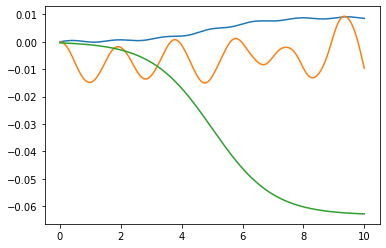

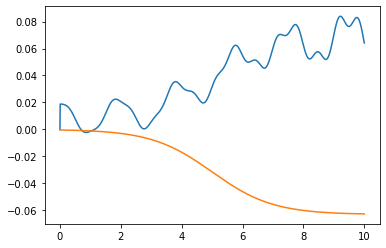

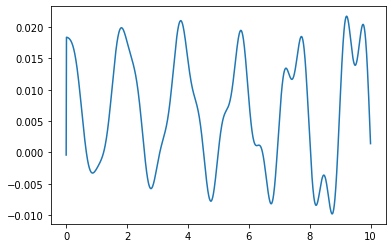

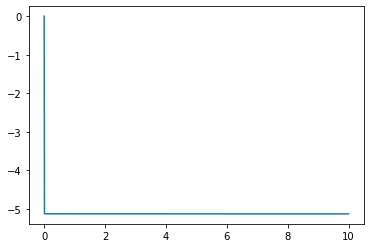

In [15]:
z_ad_image=z_adiabatic.detach().cpu().numpy()
z_image=z_torch.detach().cpu().numpy()
h_image=h_torch.detach().cpu().numpy()
grad_image=grad.detach().cpu().numpy()
f_image=f.detach().cpu().numpy()


plt.plot(time,z_image[:,0])
plt.plot(time,z_ad_image[:,0])
plt.plot(time,h_image[:,0])
#plt.ylim([-1,1])
plt.show()
    

plt.plot(time,grad_image[:,0])
plt.plot(time,h_image[:,0])
#plt.ylim([-1,1])
plt.show()
    

plt.plot(time,grad_image[:,0]+h_image[:,0])

#plt.ylim([-1,1])
plt.show()
    
plt.plot(time,f_image)
plt.show()

In [ ]:
for i in range(f_image.shape[0]):
    if np.abs(f_image[i])>0.5:
        print(i*dt)
        plt.plot(-1*grad_image[i-2,:])
        plt.plot(h_image[i-2,:])

        plt.show()

#### Use the DL-DFT energy functional as a semiclassical approximation (for sure it works in the Adiabatic Limit)

Imports